# Задание 1:  A/B тестирование
В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. Необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

**Входные данные**

В качестве входных данных Вы имеете 4 csv-файла:  
    groups.csv - файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа)   
    groups_add.csv - дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных  
    active_studs.csv - файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента.   
    checks.csv - файл с информацией об оплатах пользователей в дни проведения эксперимента. 

**Требования к ответу**  
    При выполнении тестового задания необходимо использовать язык программирования Python.   
    В файле обязательно должны быть комментарии к тем действиям, которые Вы выполняете с данными.  
    Файл должен представлять собой законченный отчёт с выводами, сделанными в ходе исследования.

In [1]:
# проверка соответствия pep8
# %load_ext pycodestyle_magic
# %pycodestyle_on --ignore E402,W291,W293 --max_line_length 120

### Импорт библиотек, скачивание файлов в датасет

In [2]:
# импорт библиотек
import pandas as pd
import numpy as np
from scipy.stats import norm, mannwhitneyu, shapiro
from statsmodels.stats import proportion
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from urllib.parse import urlencode
%matplotlib inline

Скачиваем файлы с Yandex Disc

In [3]:
# ссылки на файлы
links = {'groups': 'https://disk.yandex.ru/d/58Us0DWOzuWAjg',
         'groups_add': 'https://disk.yandex.ru/d/3aARY-P9pfaksg',
         'active_studs': 'https://disk.yandex.ru/d/prbgU-rZpiXVYg',
         'checks': 'https://disk.yandex.ru/d/84hTmELphW2sqQ',
         }

base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'

# Получаем загрузочные ссылки на 4 файла в словаре
download_urls = {}
for link in links:
    final_url = base_url + urlencode(dict(public_key=links[link]))
    response = requests.get(final_url)
    download_urls[link] = response.json()['href']

Считываем файлы в датафреймы

In [4]:
# функция, характеризующая датафрейм
def df_about(df,
             groups_ids=False,
             student_col=0,
             group_col=1):
    """
    Функция возращает информацию о количестве строк, дублирующихся строках, пропущенных значениях,
    распределению пользователей по группам.
        df - датафрейм
        groups_ids=False - есть ли колонка с обозначением группы
        student_col=0 - номер колонки с id пользователя
        group_col=1) -  номер колонки с обозначением группы
    """
    print(f'Всего строк:{df.shape[0]}')
    print(f'Дублирующихся строк по пользователям: {df.iloc[:, student_col].duplicated().sum()}')
    print(f'\nПропущенных значений: \n{df.isna().sum()}')
    if groups_ids:
        print(f'\nКоличество пользователей в группах: \n{df.iloc[:, group_col].value_counts()}')
        print(f'\n - в процентах:\n{df.iloc[:, group_col].value_counts(normalize=True).mul(100).round(2)}')

In [5]:
# данные о принадлежности пользователя к контрольной или экспериментальной группе
# (А – контроль, B – целевая группа)
groups = pd.read_csv(download_urls['groups'], sep=';')
groups.head(2)

,id,grp
0,1489,B
1,1627,A


In [6]:
df_about(groups, groups_ids=True)

Всего строк:74484
Дублирующихся строк по пользователям: 0

Пропущенных значений: 
id     0
grp    0
dtype: int64

Количество пользователей в группах: 
B    59813
A    14671
Name: grp, dtype: int64

 - в процентах:
B    80.3
A    19.7
Name: grp, dtype: float64


In [7]:
# дополнительный файл с пользователями, который прислали спустя 2 дня после передачи данных
groups_add = pd.read_csv(download_urls['groups_add'])
groups_add.head(2)

,id,grp
0,5694584,B
1,5694830,B


In [8]:
df_about(groups_add, groups_ids=True)

Всего строк:92
Дублирующихся строк по пользователям: 0

Пропущенных значений: 
id     0
grp    0
dtype: int64

Количество пользователей в группах: 
B    70
A    22
Name: grp, dtype: int64

 - в процентах:
B    76.09
A    23.91
Name: grp, dtype: float64


In [9]:
# объединим данные в один датасет
groups = groups.append(groups_add)
df_about(groups, groups_ids=True)

Всего строк:74576
Дублирующихся строк по пользователям: 0

Пропущенных значений: 
id     0
grp    0
dtype: int64

Количество пользователей в группах: 
B    59883
A    14693
Name: grp, dtype: int64

 - в процентах:
B    80.3
A    19.7
Name: grp, dtype: float64


In [10]:
# пользователи, которые зашли на платформу в дни проведения эксперимента
active_studs = pd.read_csv(download_urls['active_studs'])
active_studs.head(2)

,student_id
0,581585
1,5723133


In [11]:
df_about(active_studs)

Всего строк:8341
Дублирующихся строк по пользователям: 0

Пропущенных значений: 
student_id    0
dtype: int64


In [12]:
# информация об оплатах пользователей в дни проведения эксперимента
checks = pd.read_csv(download_urls['checks'], sep=';')
checks.head(2)

,student_id,rev
0,1627,990.0
1,3185,690.0


In [13]:
df_about(checks)

Всего строк:541
Дублирующихся строк по пользователям: 0

Пропущенных значений: 
student_id    0
rev           0
dtype: int64


## Определение метрик

Разделение пользователей на группы произведено неравномерно, соотношение целевой и контрольной составляет 80/20 (т.е. изменение механики оплаты предложено гораздо большему количеству пользователей - если бы компания не ожидала с большой долей вероятности значимый положительный эффект от этого изменения, распределение было бы 50/50 либо новая механика была бы предложена меньшей доле пользователей).  
В таких условиях есть смысл рассматривать только относительные метрики, приведенные к количеству пользователей.  
По результатам теста нам доступны данные по пользователям, которые зашли на платформу в дни эксперимента, совершили оплату (или оплаты), а также объемы оплат. 
Оценим:
 - ARPPU (средний доход на платящего пользователя), 
 - ARPAU (средний доход на активного пользователя),
 - ARPU (средний доход на привлеченного пользователя),
 - CR (конверсия в оплату),
 - CR_A (конверсия активного пользователя в оплату)

$ARPPU = \frac{Доход}{Количество \ пользователей, \ совершивших \ оплату}$

$ARPAU = \frac{Доход}{Количество \ активных \ пользователей}$

$ARPU = \frac{Доход}{Количество \ пользователей}$

$CR = \frac{ Количество \ пользователей, \ совершивших \ оплату }{ Количество \ пользователей} $$\times 100 $ % 

$CR_A = \frac{ Количество \ пользователей, \ совершивших \ оплату }{ Количество \ активных \ пользователей} $$\times 100 $ % 

В качестве целевых метрик, для которых определим значимость различия в группах, выступают ARPPU и СR.

<strong>Сведем данные в один датасет</strong>  
(к данным по пользователям в разрезе групп добавим данные по пользователеям, зашедшим на платформу в дни проведения эксперимента (введем столбец с меткой "1" для активных), и данные по оплатам)

In [14]:
df = groups \
    .rename(columns={'id': 'student_id'}) \
    .merge(active_studs.assign(activity=1), how='outer', on='student_id') \
    .merge(checks, on='student_id', how='outer') \
    .rename(columns={'grp': 'group', 'rev': 'revenue'})
df.head()

,student_id,group,activity,revenue
0,1489,B,NaN,NaN
1,1627,A,1.0,990.0
2,1768,B,NaN,NaN
3,1783,B,NaN,NaN
4,1794,A,NaN,NaN


In [15]:
df_about(df, groups_ids=True)

Всего строк:74576
Дублирующихся строк по пользователям: 0

Пропущенных значений: 
student_id        0
group             0
activity      66235
revenue       74035
dtype: int64

Количество пользователей в группах: 
B    59883
A    14693
Name: group, dtype: int64

 - в процентах:
B    80.3
A    19.7
Name: group, dtype: float64


Пропущенных значений в первых двух колонках нет, значит, учтены все пользователи. 
Проверим, нет ли оплат, совершенных неактивными пользователями

In [16]:
missed_active_df = df.query("activity != 1 & revenue.notna()")
missed_active_df.count()

student_id    149
group         149
activity        0
revenue       149
dtype: int64

In [17]:
missed_active_df.groupby('group').agg({'student_id': 'count'})

,student_id
group,
A,29
B,120


В данных 149 пользоватей, совершивших оплату и не указанные в числе активных. При этом количество пользователей в группах пропорционально размеру групп. Возможно, это связано с ошибками при логировании. Отметим этих пользователей меткой '1' в колонке activity. Затем всем остальным, неактивным, присвоим значение активности '0'.

In [18]:
df = missed_active_df \
    .fillna(1) \
    .append(df.loc[~df.student_id.isin(missed_active_df['student_id'])])
df.activity.fillna(0, inplace=True)

In [19]:
df_about(df, groups_ids=True)

Всего строк:74576
Дублирующихся строк по пользователям: 0

Пропущенных значений: 
student_id        0
group             0
activity          0
revenue       74035
dtype: int64

Количество пользователей в группах: 
B    59883
A    14693
Name: group, dtype: int64

 - в процентах:
B    80.3
A    19.7
Name: group, dtype: float64


## Расчет метрик

In [20]:
# визуализируем распределения сумм оплат в каждой из групп
def revenue_dist_plot(data):
    """
    Функция строит графики распределения сумм оплат в разрезе групп (гистограмму, скрипичную диаграмму и ящик с усами)
    """
    sns.set_theme(style="whitegrid", palette='winter')
    sns.set_palette('colorblind')

    fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(16, 5))
    fig.suptitle('Распределение сумм оплат в контрольной (А) и целевой (B) группах', fontsize=16)

    sns.histplot(data=data, x='revenue', hue='group', ax=ax1, bins=30, stat='density', hue_order=['A', 'B'])
    ax1.set(xlabel='', ylabel='density', title='')

    sns.violinplot(data=data, x='revenue', y='group', ax=ax2, order=['A', 'B'])
    ax2.set(xlabel='', ylabel='group', title='')

    sns.boxplot(data=data, x='revenue', y='group', ax=ax3, order=['A', 'B'])
    ax3.set(xlabel='', ylabel='', title='')

    fig.text(0.5, 0.00, 'Сумма оплаты, руб.', va='center', ha='center', fontsize=14)
    fig.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

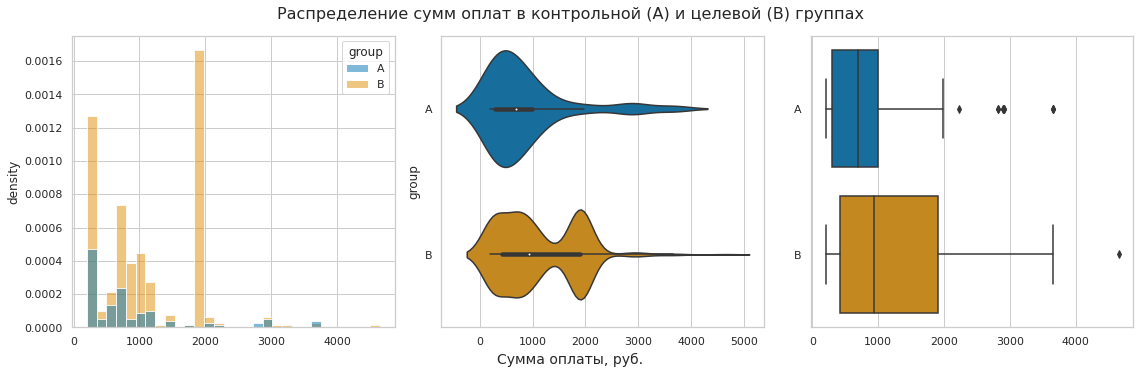

In [21]:
revenue_dist_plot(df)

Как видим, распределения далеки от нормальных, скошены вправо. Максимальные суммы значительно превышают медианные значения. Наблюдаем несколько выбросов, удалять их из фрейма для целей оценки результатов теста считаю нецелесообразным, так как они характеризуют особо активных студентов и наблюдаются в обеих группах.  
Стоит отметить, что распределение в целевой группе полимодально: наиболее часто отмечены не только оплаты в пределах 300 и 700 руб.(что характерно и для контрольной группы), но и в размере 1900 руб. Поэтому медиана распределения в целевой группе находится практически на границе третьего квартиля распределения в контрольной группе.  
**Рассчитаем значения метрик**:

In [22]:
# заведем отдельный датафрейм для формирования таблицы метрик по группам
metrics = pd.DataFrame(index=['A', 'B'])

# всего пользователей-студентов
metrics['users'] = df.groupby('group') \
                     .agg({'student_id': 'count'}).student_id

# количество активных студентов
metrics['active_users'] = df.groupby('group') \
                            .agg({'activity': 'sum'}).activity

# количество платящих студентов
metrics['paying_users'] = df.groupby('group') \
                            .agg({'revenue': 'count'}).revenue

# совокупный доход
metrics['revenue'] = df.groupby('group') \
                       .agg({'revenue': 'sum'})

# соответствующие метрики
metrics['ARPPU'] = metrics.revenue / metrics.paying_users

metrics['ARPAU'] = metrics.revenue / metrics.active_users

metrics['ARPU'] = metrics.revenue / metrics.users

metrics['CR'] = metrics.paying_users / metrics.users * 100

metrics['CR_A'] = metrics.paying_users / metrics.active_users * 100

# оформим таблицу, отметим более высокие значения метрик синим
metrics.style.highlight_max(subset=['ARPPU', 'ARPAU', 'ARPU', 'CR', 'CR_A'], color='#91A5EB') \
             .format("{:.2f}", subset=metrics.columns.drop(['paying_users', 'active_users', 'users'])) \
             .format("{:.0f}", subset=['active_users', 'revenue']) \
             .set_caption('Метрики по контрольной (А) и целевой (В) группам')

,users,active_users,paying_users,revenue,ARPPU,ARPAU,ARPU,CR,CR_A
A,14693,1567,107,92096,860.71,58.77,6.27,0.73,6.83
B,59883,6923,434,481230,1108.82,69.51,8.04,0.72,6.27


In [23]:
# рассчитаем разницу между показателями целевой и контрольной групп
metrics_diff = metrics[['ARPPU', 'ARPAU', 'ARPU', 'CR', 'CR_A']].T

# в абсолютном выражении
metrics_diff['diff'] = (metrics_diff.B - metrics_diff.A).round(2)

# в относительном выражении (в %)
metrics_diff['diff_percent'] = (metrics_diff.B - metrics_diff.A).div(metrics_diff.A).mul(100).round(2)
metrics_diff.drop(columns=['A', 'B'])

,diff,diff_percent
ARPPU,248.11,28.83
ARPAU,10.74,18.27
ARPU,1.77,28.21
CR,-0.00,-0.48
CR_A,-0.56,-8.19


Как видим, пользователи, которым была предложена новая механика оплаты, в среднем обеспечили больший доход, хотя конверсия в покупку оказалась несколько ниже. Оценим статистическую значимость полученных разниц.

## Оценим значимость полученных результатов

#### ARPPU

Так как значения сумм оплат распределены ненормально, размеры независимых выборок значительно отличаются, для сравнения их статистической однородости воспользуемся U-критерием Манна-Уитни. 

**Нулевая гипотеза:** законы распределения сумм оплат в контрольной и целевой группах не отличаются ($F_{A} = F_{B}$)  
**Альтернативная гипотеза:** законы распределения сумм оплат в контрольной и целевой группах отличаются  (соответственно, $F_{A} < F_{B}$)

In [24]:
# разделим данные на контрольную и целевую выборки
a_group = df[df.group == 'A'].dropna().revenue
b_group = df[df.group == 'B'].dropna().revenue

In [25]:
# удостоверимся еще раз в ненормальности распределений
def normality_test(data, alpha=0.05):
    if shapiro(data).pvalue > alpha:
        print('Распределение нормальное')
    else:
        print('Распределение ненормальное')


normality_test(a_group)
normality_test(b_group)

Распределение ненормальное
Распределение ненормальное


In [26]:
mannwhitneyu(a_group, b_group)

MannwhitneyuResult(statistic=17862.0, pvalue=0.00019316054996380152)

Значение U-критерия значительно меньше 0,05. Учитывая, что критерий Манна-Уитни, как и любой статистический оценщик, чувствителен к дисбалансу размера выборок (т.е. чем сильнее дисбаланс, тем реже критерий будет обнаруживать реальную разницу), все это позволяет нам отклонить нулевую гипотезу.
Делаем вывод о том, что полученное 29-процентное превышение ARPPU в целевой группе статистически значимо.  
Также проверим этот вывод, применив бутстрап.

**Нулевая гипотеза:** средние значения в генеральных совокупностях контрольной и целевой групп равны (соответственно, $ARPPU_{A} = ARPPU_{B}$)  
**Альтернативная гипотеза:** средние значения в генеральных совокупностях контрольной и целевой групп не равны (соответственно, $ARPPU_{A} < ARPPU_{B}$)

In [27]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа
def get_bootstrap(
    data_column_1,  # числовые значения целевой выборки
    data_column_2,  # числовые значения контрольной выборки
    boot_it=10000,  # количество бутстрэп-подвыборок
    statistic=np.mean,  # интересующая нас статистика
    bootstrap_conf_level=0.95,  # уровень значимости
    vizualize=True   # визуализация
):
    """
    Функция позволяет проверить гипотезу о равенстве выбранной статистики двух распределений с помощью бутстрапа,
    возвращает значение p-value, доверительный интервал, оценку разницы статистик,
    визуализирует распределение разниц статистик
    """
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in range(boot_it):  # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len,
            replace=True   # параметр возвращения
        ).values

        samples_2 = data_column_2.sample(
            boot_len,
            replace=True
        ).values

        boot_data.append(statistic(samples_1 - samples_2))   # применяем статистику

    pd_boot_data = pd.DataFrame(boot_data)

    left_quant = (1 - bootstrap_conf_level) / 2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])   # границы доверительного интервала

    p_1 = norm.cdf(
        x=0,
        loc=np.mean(boot_data),
        scale=np.std(boot_data)
    )
    p_2 = norm.cdf(
        x=0,
        loc=-np.mean(boot_data),
        scale=np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2

    # Визуализация
    if vizualize:
        plt.hist(pd_boot_data[0], bins=50)
        plt.style.use('ggplot')
        plt.vlines(ci, ymin=0, ymax=50, linestyle='--')
        plt.xlabel('boot_data')
        plt.ylabel('frequency')
        plt.title("Histogram of boot_data")
        plt.show()

    return {"boot_data": boot_data,   # разница двух распределений
            "ci": ci,   # доверительный интервал
            "p_value": p_value}

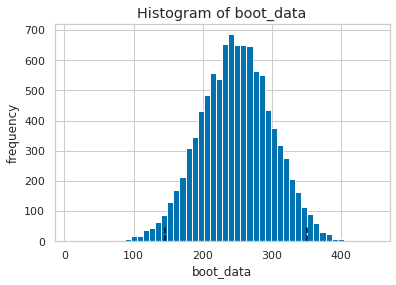

P-value: 2.264541862943425e-06
Доверительный интервал:            0
0.025  145.7
0.975  349.8
Среднее для разницы двух распределений: 247.91


In [28]:
# Применим бутстрап (с np.mean):
booted_data = get_bootstrap(b_group, a_group, boot_it=10000, statistic=np.mean)
print(f"P-value: {booted_data['p_value']}")
print(f"Доверительный интервал: {booted_data['ci'].round(1)}")
print(f"Среднее для разницы двух распределений: {round(np.mean(booted_data['boot_data']), 2)}")

Результаты позволяют отклонить нулевую гипотезу и сделать вывод о значимом превышении среднего значения в целевой группе над соответствующим значением в контрольной группе.

**Вывод по ARPPU**   
В целевой группе показатель выше на 29%, разница статистически значима, можно предложить новую механику оплаты всем пользователям.

#### КОНВЕРСИЯ

Также оценим статистическую значимость разницы в коэффициентах конверсии в обеих группах. Прежде всего, нас интересует отношение платящих пользователей к активным ($CR_{A}$), так как именно они ознакомлены с новой механикой оплаты.
С учетом того, что число конверсий подчиняется биномиальному распределению, оценим p-уровень значимости и доверительный интервал разницы отношений в двух группах.

In [29]:
# создадим датафрейм, в котором значения revenue заменим на 1 и 0 в зависимости от наличия факта оплаты
cr_df = df[['student_id', 'revenue']]
cr_df['revenue'] = cr_df['revenue'].notna().apply(int)
cr_df = cr_df.merge(df.drop(columns=['revenue']), on='student_id')
cr_df.head()

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,student_id,revenue,group,activity
0,3185,1,B,1.0
1,25973,1,B,1.0
2,26280,1,B,1.0
3,100645,1,B,1.0
4,102534,1,B,1.0


**Нулевая гипотеза:** $CR_{A}(B) - CR_{A}(A) = 0$  
**Альтернативная гипотеза:** $CR_{A}(B) - CR_{A}(A) \not=0$

In [30]:
# выделим выборки целевой и контрольной групп
a_group = cr_df[(cr_df.activity == 1) & (cr_df.group == 'A')].revenue
b_group = cr_df[(cr_df.activity == 1) & (cr_df.group == 'B')].revenue

In [31]:
# результат сравнения двух независимых отношений (pvalue и оценка абсолютной разницы показателей)
cra_test_results = proportion.test_proportions_2indep(b_group.sum(), b_group.count(), a_group.sum(), a_group.count())
print(f'P-value: {cra_test_results.pvalue}')
print(f'Оценка CRA_B - CRA_A: {cra_test_results.diff}')

# доверительный интервал разницы
print('Доверительный интервал разницы значений:')
proportion.confint_proportions_2indep(b_group.sum(), b_group.count(), a_group.sum(), a_group.count())

P-value: 0.39166211669576845
Оценка CRA_B - CRA_A: -0.005593758529530007
Доверительный интервал разницы значений:


(-0.020228542905411432, 0.0073235306577362005)

Результат не позволяет отклонить нулевую гипотезу, доверительный интервал включает ноль - значит, разницу коэффициентов конверсии **CR_A** нельзя признать статистически значимой.  
Проделаем те же операции для коэффициента конверсии **CR:**

In [32]:
a_group = cr_df[cr_df.group == 'A'].revenue
b_group = cr_df[cr_df.group == 'B'].revenue

In [33]:
# результат сравнения двух независимых отношений (pvalue и оценка абсолютной разницы показателей)
cr_test_results = proportion.test_proportions_2indep(b_group.sum(), b_group.count(), a_group.sum(), a_group.count())
print(f'P-value: {cr_test_results.pvalue}')
print(f'Оценка CRA_B - CRA_A: {cr_test_results.diff}')

# доверительный интервал разницы
print('Доверительный интервал разницы значений:')
proportion.confint_proportions_2indep(b_group.sum(), b_group.count(), a_group.sum(), a_group.count())

P-value: 0.9132973272663066
Оценка CRA_B - CRA_A: -3.491347250076087e-05
Доверительный интервал разницы значений:


(-0.0016777533880380782, 0.0014051113850079028)

Аналогичный результат: нулевую гипотезу отклонить нельзя, оцениваемая разница коэффициентов очень мала, доверительный интервал включает ноль. Делаем вывод об отсутствии статистически значимой разницы между коэффициентами конверсии в двух группах.

## Вывод по итогам проведенного теста:   

## полученная разница в значениях ARPPU статистически значима, в целевой группе показатель выше на 29%. При этом статистически значимой разницы в значениях конверсии не обнаружено.  
## Как итог -  можно предложить новую механику оплаты всем пользователям.

#    Задание 3
Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.  
Реализуйте функцию, которая будет строить графики по получаемым метрикам.  

In [34]:
def add_data(groups_add_path='groups_add.csv',
             groups=groups,
             checks=checks,
             active_studs=active_studs):
    """
    функция подгружает информацию из дополнительного файла groups_add.csv (заголовки могут отличаться)
    и на основании дополнительных параметров пересчитываeт метрики.

    Параметры:
        groups_add_path = 'groups_add.csv', - дополнительный файл
        groups=groups  - распределение пользователей по группам
        checks=checks  - данные по оплатам
        active_studs=active_studs  - данные по активности пользователей

     Возвращает датафрейм с метриками по группам
    """
    # переименовываем колонки в student_id и group
    groups = groups.rename(columns={'id': 'student_id', 'grp': 'group'})

    # считываем файл, переименовываем колонки в student_id и group
    groups_add = pd.read_csv(groups_add_path, sep=';')
    for col in groups_add.columns:
        if set(groups_add[col].unique()) == set(groups.group.unique()):
            groups_add.rename(columns={col: 'group'})
        else:
            groups_add.rename(columns={col: 'student_id'})

    # объединим данные по принадлежности к группам
    groups = groups.append(groups_add).drop_duplicates()

    # добавим колонку активности в active_studs
    active_studs = active_studs.assign(activity=1)

    # сведем данные в один датасет
    df = groups \
        .merge(active_studs.assign(activity=1), how='left', on='student_id') \
        .merge(checks, on='student_id', how='left') \
        .rename(columns={'rev': 'revenue'})

    # Проверим, нет ли оплат, совершенных неактивными пользователями.
    # Отметим этих пользователей меткой '1' в колонке activity, остальным, неактивным, присвоим значение активности '0'.
    missed_active_df = df.query("activity != 1 & revenue.notna()")
    print(f'Пользователей, оплативших курсы и не отмеченных, как активные: {missed_active_df.student_id.count()}')
    df = missed_active_df.fillna(1) \
        .append(df.loc[~df.student_id.isin(missed_active_df['student_id'])])
    df.activity.fillna(0, inplace=True)

    # заведем отдельный датафрейм для формирования таблицы метрик по группам
    metrics = pd.DataFrame(index=['A', 'B'])
    metrics['users'] = df.groupby('group').agg({'student_id': 'count'}).student_id
    metrics['active_users'] = df.groupby('group').agg({'activity': 'sum'}).activity
    metrics['paying_users'] = df.groupby('group').agg({'revenue': 'count'}).revenue
    metrics['revenue'] = df.groupby('group').agg({'revenue': 'sum'})

    # соответствующие метрики
    metrics['ARPPU'] = metrics.revenue / metrics.paying_users
    metrics['ARPAU'] = metrics.revenue / metrics.active_users
    metrics['ARPU'] = metrics.revenue / metrics.users
    metrics['CR'] = metrics.paying_users / metrics.users * 100
    metrics['CR_A'] = metrics.paying_users / metrics.active_users * 100

    return metrics

In [35]:
def metrics_plot(metrics=metrics.reset_index(), full_data=df):
    """
    Функция строит графики по полученным метрикам
    metrics=metrics.reset_index() - таблица метрик
    full_data=df - данные для расчета метрик (для построения графика по распределению сумм оплат по группам)
    """
    # распределение сумм оплат по группам
    revenue_dist_plot(full_data)

    # столбичные графики по метрикам в разрезе групп
    sns.set_theme(style="whitegrid", palette='winter')
    sns.set_palette('colorblind')

    fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 5))
    fig.suptitle('Сравнение рассчитанных метрик в контрольной (А) и целевой (В) группах', fontsize=18)

    metrics_list = ['ARPPU', 'ARPAU', 'ARPU', 'CR', 'CR_A']
    titles = ['ARPPU', 'ARPAU', 'ARPU', 'Конверсия в покупку', 'Конверсия активных пользователей в покупку']
    for title, metric, ax in zip(titles, metrics_list, axes.flatten()):
        sns.barplot(x='index', y=metric, data=metrics, ax=ax)
        ax.set(title=title, xlabel='', ylabel='')

    fig.tight_layout()
    plt.subplots_adjust(top=0.8)
    plt.show()

In [36]:
add_data(groups_add_path=download_urls['groups'])

Пользователей, оплативших курсы и не отмеченных, как активные: 149


,users,active_users,paying_users,revenue,ARPPU,ARPAU,ARPU,CR,CR_A
A,14693,1567.0,107,92096.0000,860.710280,58.772176,6.268019,0.728238,6.828334
B,59883,6923.0,434,481230.0036,1108.824893,69.511773,8.036171,0.724747,6.268959


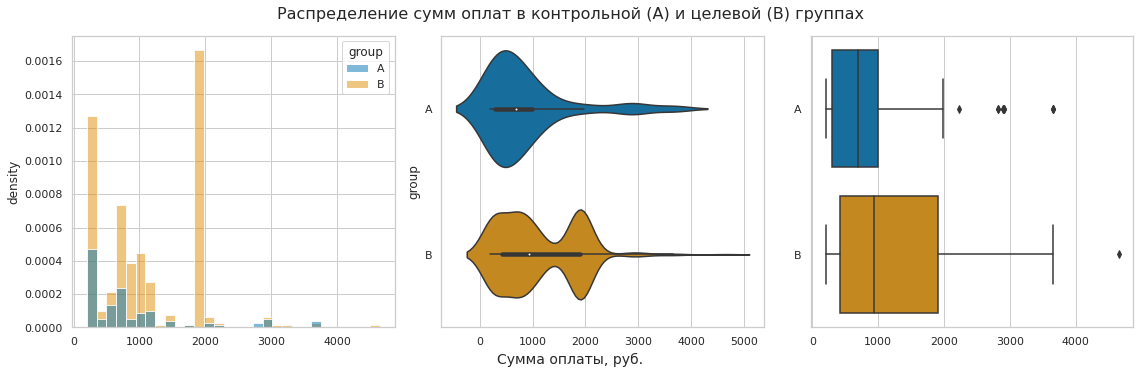

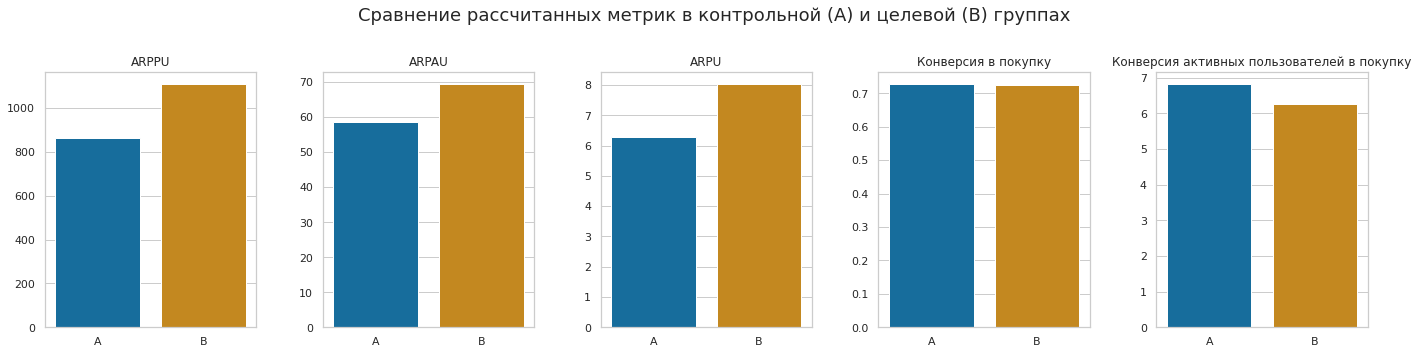

In [37]:
metrics_plot()